# Chapter 67 (Convolutional Networks)

### Runs simulations for Example 6 in Chapter 67: Convolutional Networks (vol. III)
TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.

<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs. The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Eduardo Faria Cabrera

required libraries:
    
1. numpy
2. matplotlib
3. scipy
4. torch
5. tqdm

In [1]:
import numpy as np
import torch 
from torch import nn
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import cv2

## Example 67.1 (Edge detection)

We consider one fundamental problem in image analysis, which relates to edge detection. Edges characterize object boundaries and are useful in many applications requiring  segmentation, registration, and identification of objects. One typical application where edge detection techniques are involved is automatic character recognition.
 
Edges in an image can be determined by identifying pixel locations where abrupt changes in the gray levels occur. If we  assume, for the sake of argument, that the intensity of the pixels varies continuously in the $(x,y)$ coordinates, where $x,y$ are now real-valued, then the derivative of the image ${\cal I}(x,y)$ at an edge location $(x,y)$ is expected to assume some local maximum value. This property motivates one technique for detecting edges by examining the gradient of ${\cal I}(x,y)$ by using gradient operators along the vertical and horizontal directions.  These operators, which are masks, compute finite-difference approximations for the gradient vectors $\partial {\cal I}(x,y)/\partial x$ and $\partial {\cal I}(x,y)/\partial y$. Two common  gradient operators are the Sobel and Prewitt operators, defined by

$$
(\textnormal{Sobel}) \;\;\; {\cal W}_{x}\overset{\Delta}{=} \begin{bmatrix}-1&0&1\\-2&\fbox{0}&2\\-1&0&1\end{bmatrix},\;\;\;\;
{\cal W}_{y}\overset{\Delta}{=} \begin{bmatrix}-1&-2&-1\\0&\fbox{0}&0\\1&2&1\end{bmatrix} \tag{67.17a}
$$

$$
(\textnormal{Prewitt}) \;\;\; {\cal W}_{x}\overset{\Delta}{=} \begin{bmatrix}-1&0&1\\-1&\fbox{0}&1\\-1&0&1\end{bmatrix},\;\;\;\;
{\cal W}_{y}\overset{\Delta}{=} \begin{bmatrix}-1&-1&-1\\0&\fbox{0}&0\\1&1&1\end{bmatrix} \tag{67.17b}
$$

These operators can be used to estimate gradients of an image at every pixel location. We center the operator at the pixel location (with the centers of the masks identified in (67.17a)--(67.17b) by the small squares around them) and evaluate the correlation of the image with the gradient operators:

$$
\cal I\;\;\stackrel{\cal W_x}{\longrightarrow}\;\cal F_x,\;\;\;\;\;\;\;\cal I\;\;\stackrel{\cal W_y}{\longrightarrow}\;\cal F_y \tag{67.18}
$$

In [259]:
img = cv2.imread("data/tools.jpg", 0)

grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)

grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

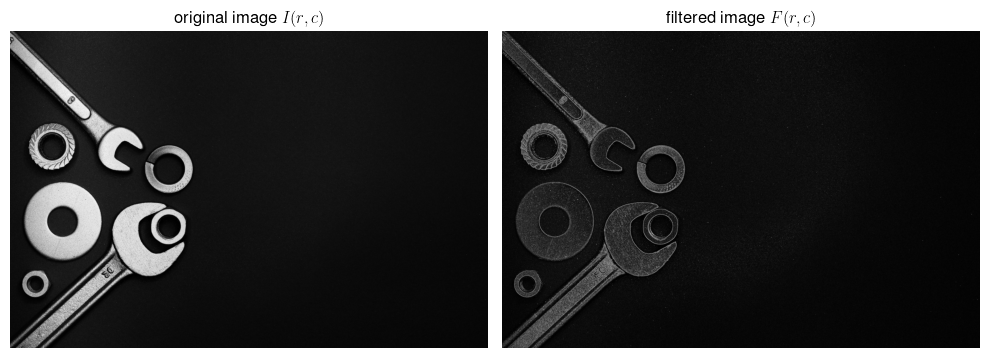

In [269]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=10, 10
fig = plt.figure()

ax = plt.subplot(121)
ax.imshow(img, cmap="gray")
plt.axis("off")
ax.set_title("original image $I(r, c)$")

ax = plt.subplot(122)
ax.imshow(grad, cmap="gray")
plt.axis("off")
ax.set_title("filtered image $F(r, c)$")

plt.tight_layout()

plt.savefig("figs/fig-7.pdf", format="pdf", bbox_inches="tight")

plt.show()

**Figure 67.7** Illustration of the edge detection procedure using the Sobel operator. The original image on the left is from the site  www.pexels.com, where photos are free to use.

Here, the notation $({\cal F}_x,{\cal F}_y)$ denotes the result of computing the gradients along the $x$ (horizontal) and $y$ (vertical) directions. Note that the Prewitt and Sobel operators compute local horizontal and vertical differences or sums. This helps reduce the effect of noise in the data. Note further that these gradient operators have the desirable property of yielding zeros for uniform regions in an image. Once we have computed the gradient values, we can combine their components along the row and column directions and determine the gradient vector magnitudes:

$$
{\cal F}(r,c)\;=\;\sqrt{\bigl({\cal F}_x(r,c)\bigr)^2+\bigl({\cal F}_y(r,c)\bigr)^2} \tag{67.19}
$$

We then decide that a pixel location $(r,c)$ is an edge location in the original image if ${\cal F}(r,c)$  is sufficiently large (i.e., larger than some threshold value) --- see Fig. 67.7. If we are interested in detecting separately the presence of horizontal and vertical edges, then the decision can be based solely on the values of  ${\cal F}_x(r,c)$ and ${\cal F}_{y}(r,c)$ exceeding appropriate thresholds. This example illustrates that different choices for a mask can be used to highlight different properties of the underlying image.

## Example 67.6 (Classification of handwritten digits)

We illustrate the operation of the CNN  by applying it to the classification of handwritten digits using the same MNIST dataset from Example 66.2. Recall that the MNIST dataset consists of 60,000 labeled training samples and 10,000 labeled testing samples. Each entry in the dataset is a 28 $\times$ 28 grayscale image, which we transform into an $M=784-$long feature vector, $h_n$. Each pixel in the image and, therefore, each entry in $h_n$, assumes integer values in the range $[0,255]$. Every feature vector (or image) is assigned an integer label in the range $0$--$9$ depending on which digit the image corresponds to. The earlier Fig. 65.12 shows randomly selected images from the training dataset. 

In [2]:
# Load dataset and transform data type to dlarray
data = scipy.io.loadmat("data/MNIST_normalized_new.mat")
XTrain = torch.tensor(data["XTrain"])
XTrain = torch.swapaxes(XTrain, -3, -2)
XTrain = torch.swapaxes(XTrain, -4, -3)
XTrain = torch.swapaxes(XTrain, -2, -1)
XTrain = torch.swapaxes(XTrain, -3, -2)
XTrain = torch.swapaxes(XTrain, -4, -3)

XTest = torch.tensor(data["XTest"])
XTest = torch.swapaxes(XTest, -3, -2)
XTest = torch.swapaxes(XTest, -4, -3)
XTest = torch.swapaxes(XTest, -2, -1)
XTest = torch.swapaxes(XTest, -3, -2)
XTest = torch.swapaxes(XTest, -4, -3)

YTrain = torch.tensor(data["YTrain"].reshape(-1))
YTest = torch.tensor(data["YTest"].reshape(-1))

n_train = XTrain.shape[0]

n_test = XTest.shape[0]

Q = 10 # number of classes
size_input = 28

In [3]:
train_dataset = [{"x": XTrain[n], "y": YTrain[n]} for n in range(n_train)]
test_dataset = [{"x": XTest[n], "y": YTest[n]} for n in range(n_test)]

In [4]:
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# Define CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(5, 5), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(8, 16, kernel_size=(5, 5), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Flatten(),
            nn.Linear(256, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        y = self.layers(x)

        return y

In [192]:
model = CNN()

# training parameters
epochs = 1
lr = 0.01 # learning rate

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
training_acc = []
test_acc = []
train_loss = []
test_loss = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    epoch_acc = []
    epoch_loss = []

    model.train()
    for batch in tqdm(train_dataloader):
        x = batch['x'].float()
        y = batch['y'].long()
        y_hat = model(x)

        loss_output = loss(y_hat, y)
        optimizer.zero_grad()
        loss_output.backward()
        optimizer.step()

        predicted_classes = torch.argmax(y_hat, 1)
        correct_classes = (predicted_classes == y).int().sum()
        accuracy = (correct_classes/predicted_classes.shape[0])*100

        epoch_acc.append(accuracy.item())
        epoch_loss.append(loss_output.item())
    
        training_acc.append(np.mean(epoch_acc))
        train_loss.append(np.mean(epoch_loss))
    print(f"Training Loss: {np.mean(epoch_loss)}.")

    epoch_acc = []
    epoch_loss = []

    model.eval()
    for batch in tqdm(test_dataloader):
        x = batch['x'].float()
        y = batch['y'].long()
        y_hat = model(x)

        loss_output = loss(y_hat, y)

        predicted_classes = torch.argmax(y_hat, 1)
        correct_classes = (predicted_classes == y).int().sum()
        accuracy = (correct_classes/predicted_classes.shape[0])*100

        epoch_acc.append(accuracy.item())
        epoch_loss.append(loss_output.item())
    
    test_acc.append(np.mean(epoch_acc))
    test_loss.append(np.mean(epoch_loss))
    print(f"Test Loss: {np.mean(epoch_loss)}.")

Epoch 1/5


100%|██████████| 469/469 [00:07<00:00, 59.25it/s]


Training Loss: 0.17470880038241968.


100%|██████████| 79/79 [00:00<00:00, 165.52it/s]


Test Loss: 0.08327667587259903.
Epoch 2/5


100%|██████████| 469/469 [00:07<00:00, 59.10it/s]


Training Loss: 0.07516806765443591.


100%|██████████| 79/79 [00:00<00:00, 165.37it/s]


Test Loss: 0.07539029282081543.
Epoch 3/5


100%|██████████| 469/469 [00:08<00:00, 55.07it/s]


Training Loss: 0.06556361438512906.


100%|██████████| 79/79 [00:00<00:00, 166.03it/s]


Test Loss: 0.0684830569956876.
Epoch 4/5


100%|██████████| 469/469 [00:08<00:00, 58.33it/s]


Training Loss: 0.06142027356782491.


100%|██████████| 79/79 [00:00<00:00, 165.71it/s]


Test Loss: 0.07454087981317617.
Epoch 5/5


100%|██████████| 469/469 [00:07<00:00, 59.54it/s]


Training Loss: 0.0594883887189081.


100%|██████████| 79/79 [00:00<00:00, 147.87it/s]

Test Loss: 0.07435584700183023.


In [6]:
len(test_dataloader)

79

In [8]:
model = CNN()
 
n_train_test = int(len(train_dataloader)/len(test_dataloader)) + 1

# training parameters
epochs = 1
lr = 0.01 # learning rate

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
training_acc = []
test_acc = []
train_loss = []
test_loss = []

iter_test_dataloader = iter(test_dataloader)

for batch_id, batch in tqdm(enumerate(train_dataloader)):

    epoch_acc = []
    epoch_loss = []

    model.train()
    x = batch['x'].float()
    y = batch['y'].long()
    y_hat = model(x)

    loss_output = loss(y_hat, y)
    optimizer.zero_grad()
    loss_output.backward()
    optimizer.step()

    predicted_classes = torch.argmax(y_hat, 1)
    correct_classes = (predicted_classes == y).int().sum()
    accuracy = (correct_classes/predicted_classes.shape[0])*100

    epoch_acc.append(accuracy.item())
    epoch_loss.append(loss_output.item())

    training_acc.append(np.mean(epoch_acc))
    train_loss.append(np.mean(epoch_loss))

    if batch_id % (n_train_test) == 0:
        model.eval()
        batch = next(iter_test_dataloader)
        x = batch['x'].float()
        y = batch['y'].long()
        y_hat = model(x)

        loss_output = loss(y_hat, y)

        predicted_classes = torch.argmax(y_hat, 1)
        correct_classes = (predicted_classes == y).int().sum()
        accuracy = (correct_classes/predicted_classes.shape[0])*100
    
        test_acc.append(np.mean(epoch_acc))
        test_loss.append(np.mean(epoch_loss))

469it [00:07, 64.99it/s]


In [12]:
len(train_loss), len(test_loss)

(469, 79)

In [30]:
training_x = np.arange(len(train_loss))
test_x = np.arange(len(train_loss), step=n_train_test)

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

training_acc_smooth = smooth(training_acc, 3)
train_loss_smooth = smooth(train_loss, 3)

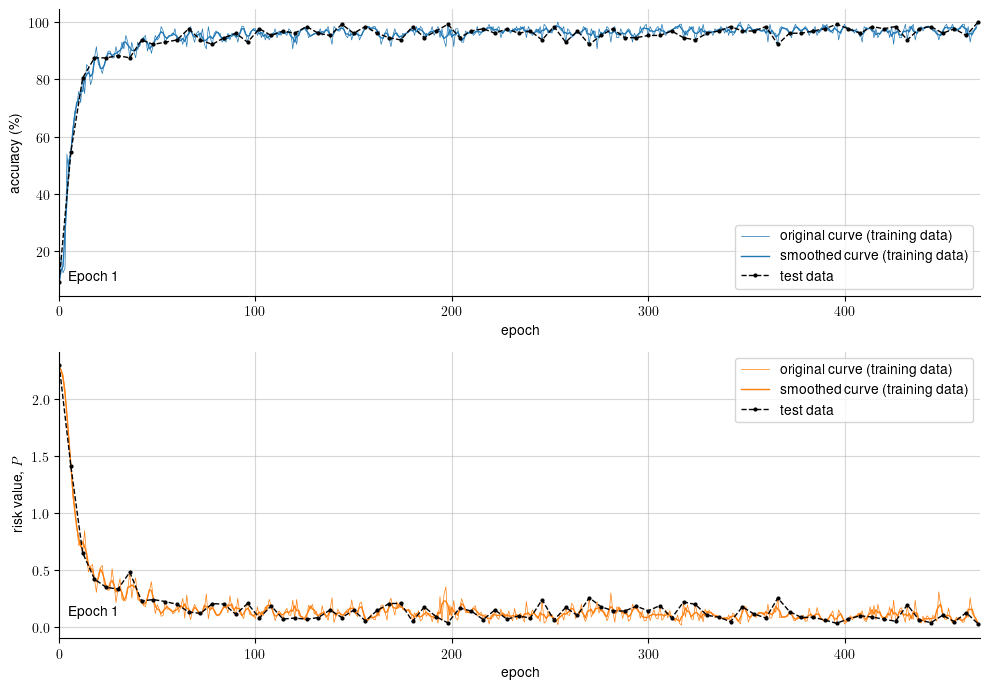

In [42]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=10, 7
fig = plt.figure()

ax = plt.subplot(211)
ax.plot(training_x, training_acc,"-", markersize=2, label="original curve (training data)", linewidth=0.5)
ax.plot(training_x[:-1], training_acc_smooth[:-1],"-", markersize=2, label="smoothed curve (training data)", linewidth=1, color="tab:blue")
ax.plot(test_x, test_acc, "--o", markersize=2, label="test data", linewidth=1, color="black")
ax.spines[['right', 'top']].set_visible(False)
plt.grid(zorder=0, alpha=0.5)
ax.set_ylabel("accuracy (\%)", fontsize=10)
ax.set_xlabel("epoch", fontsize=10)
ax.set_xlim([0, 469])
ax.annotate("Epoch 1", xy=(5, 10))
plt.legend(loc=4)

ax = plt.subplot(212)
ax.plot(training_x, train_loss,"-", markersize=2, label="original curve (training data)", linewidth=0.5, color="tab:orange")
ax.plot(training_x[1:], train_loss_smooth[1:],"-", markersize=2, label="smoothed curve (training data)", linewidth=1, color="tab:orange")
ax.plot(test_x, test_loss, "--o", markersize=2, label="test data", linewidth=1, color="black")
ax.spines[['right', 'top']].set_visible(False)
plt.grid(zorder=0, alpha=0.5)
ax.set_ylabel("risk value, $P$", fontsize=10)
ax.set_xlabel("epoch", fontsize=10)
ax.set_xlim([0, 469])
ax.annotate("Epoch 1", xy=(5, 0.1))
plt.legend()

plt.tight_layout()

plt.savefig("figs/fig-23.pdf", format="pdf", bbox_inches="tight")


plt.show()

**Figure 67.23** ($\textit{Top}$) Evolution of the accuracy rate over time during the first epoch, computed for both the training and test data. ($\textit{Bottom}$) Evolution of the risk value over time during the first epoch, computed for both the training and test data.

In the simulations in this example, we normalize the images to have pixel values within the range $[-1,1]$. We construct a convolutional network with the following structure:


1. an input layer with  depth $D_o=1$ and size $28 \times 28$;
2. a first convolutional layer with depth $D_1=8$ and mask size $5\times 5$ for each of the $8$ filters;
3. a second convolutional layer with depth $D_2=16$ and the same mask size of $5\times 5$ for each of the $16$ filters;
4. a feedforward neural network with $3$ hidden layers with $(120,84,10)$ units in each layer, respectively. The output layer has $Q=10$ output nodes connected through  a softmax evaluation;
5. all convolutional and hidden layers employ the ReLu activation function;
6. all pooling layers use max-pooling with masks of size $2\times 2$.

The network is trained over five epochs with random reshuffling, using mini-batches of size $E=128$ samples per iteration  and step-size parameters $\mu_1=\mu_2=0.01$. The network is simulated using the Matlab deep learning toolbox\footnote{Matlab is a registered trademark of MathWorks, 24 Prime Park Way, Natick, MA 01760-1500.} and the plots in Fig. 67.23 are generated. The top plot shows the evolution of the accuracy rate (the fraction of correct classifications) computed in two ways: The noisy curve reflects the accuracy values computed over the successive mini-batches (this curve is smoothed in the plot), while the dashed curve reflects the accuracy values over the test data. The bottom plot shows the evolution of the risk value  over the successive mini-batches (and its smoothed version) and over the test data. The overall accuracy rate over the test data is 97.36\%.  Figure 67.24 plots the 16 feature maps obtained at the second convolutional layer (in grayscale and in color for illustration purposes).

In [ ]:
# generate features maps

example = XTrain[0]
example = example.unsqueeze(0)

In [235]:
example_ = model.layers[0](example.float())
example_ = model.layers[1](example_)
example_ = model.layers[2](example_)
example_ = model.layers[3](example_)
feature_maps = example_.squeeze()

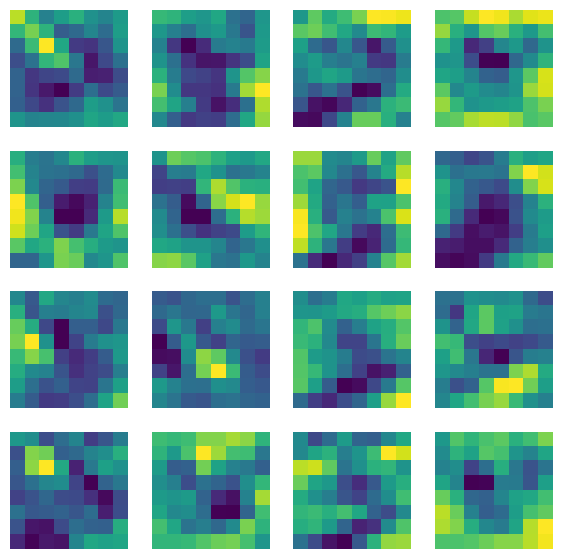

In [244]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=7, 7
fig = plt.figure()

for i in range(feature_maps.shape[0]):
    ax = plt.subplot(4, 4, i+1)
    ax.imshow(feature_maps[i].detach().numpy())
    plt.axis('off')

plt.savefig("figs/fig-24_rgb.pdf", format="pdf", bbox_inches="tight")

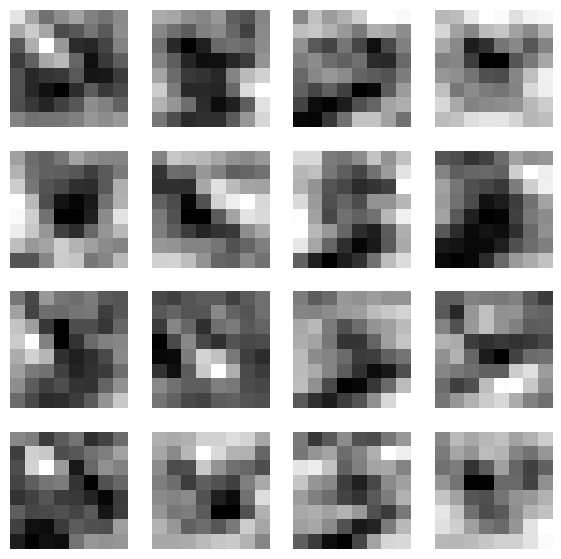

In [245]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=7, 7
fig = plt.figure()

for i in range(feature_maps.shape[0]):
    ax = plt.subplot(4, 4, i+1)
    ax.imshow(feature_maps[i].detach().numpy(), cmap="gray")
    plt.axis('off')

plt.savefig("figs/fig-24_gray.pdf", format="pdf", bbox_inches="tight")

**Figure 67.24** Plots of the 16 feature maps corresponding to the second convolutional layer in grayscale and in color.